# Recommendation Engine Project

## Overview

This recommendation engine project is designed to provide personalized recommendations intermittently based on two different approaches: a statistical approach inspired by IMDB's weighted rating formula and Singular Value Decomposition (SVD) using the Surprise framework.

## Project Components

### 1. Statistical Approach (IMDB Formula)

#### Overview
- This method mirrors IMDB's way of rating movies to find the best-rated products.

#### Workflow
- Create a metric to score or rate the products.
- Calculate the score for every product using the IMDB's weighted rating formula.
- Sort the scores and recommend the top-rated products.

### 2. Machine Learning Approach (SVD)

#### Overview
- This approach utilizes Singular Value Decomposition (SVD) provided by the Surprise framework.
- SVD is a matrix factorization technique that decomposes the user-item interaction matrix into user and item latent factors.

#### Workflow
- Use the Surprise framework to load the dataset and define the rating scale.
- Apply SVD to factorize the user-item matrix and learn latent factors.
- Train the model using the factorized matrix.
- Make intermittent predictions based on the trained model.

## Deployment Strategy

The recommendation engine is designed to work intermittently, providing recommendations at specific intervals or in response to certain events. This approach helps manage computational resources efficiently and aligns with the periodic nature of recommendation updates.

## Conclusion

By combining a statistical approach inspired by IMDB's weighted rating formula with the advanced matrix factorization technique of Singular Value Decomposition (SVD), this recommendation engine project aims to deliver accurate and diverse recommendations for users in an intermittent operational mode.


# Step #1 : import necessary framworks/libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import sparse
import datetime
import surprise
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import operator
from surprise.model_selection import train_test_split
%matplotlib inline
from surprise import SVD, Reader, Dataset 
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.metrics import classification_report
from collections import defaultdict
from surprise.model_selection import cross_validate
from surprise import KNNBasic, SVD, NormalPredictor, KNNBaseline,KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering, Reader, dataset, accuracy,dump
import random

my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

# from surprise.prediction_algorithms.algo_base import precision_at_k
%matplotlib inline


# Step #2: Load and explore the data: 

In [2]:
df = pd.read_csv('data.csv', names=['userId', 'productId', 'rating', 'timestamp']).drop(columns='timestamp')
# Show df to get an idea of the data
df.head()

,userId,productId,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


Check Null values

In [3]:
print(df[df.duplicated(['userId', 'productId'], keep=False)])

Empty DataFrame
Columns: [userId, productId, rating]
Index: []


In [4]:
df.isnull().sum()

userId       0
productId    0
rating       0
dtype: int64

we can see that our data has no null values

Now lets explore the user and product columns

In [5]:
print('Number of unique users:',df['userId'].nunique(dropna=False))
print('Number of unique products:',df['productId'].nunique(dropna=False))


Number of unique users: 4201696
Number of unique products: 476002


Now lets explore the products ratings

In [6]:
df.describe()

,rating
count,7.824482e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


In [7]:
df['rating'].value_counts()

rating
5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: count, dtype: int64

<Axes: >

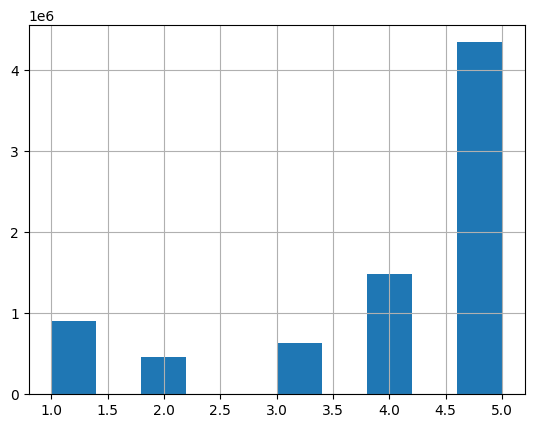

In [8]:
df['rating'].hist()

We can see that most of our products has a rating within 4-5/5 , which is a good thing 

Now lets explore our top-10 products in sales

<Axes: xlabel='productId'>

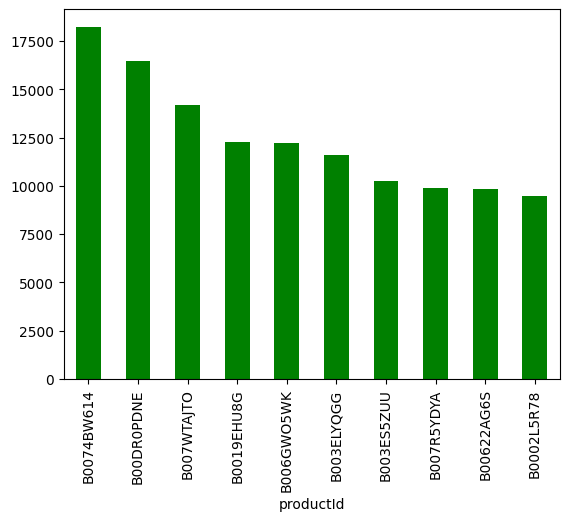

In [9]:
#top 10 products based on sales: 
df['productId'].value_counts()[0:10].plot(kind = "bar", color='g')

# Step #3 : Build a recommendation engine / algorithm 

## 1. Statistical Approach (IMDB Formula)
## Popularity/Rank-Based Recommendations

Implementing Popularity-Based Filtering is a straightforward process. We simply need to organize our products based on their ratings and present the top-rated items from our list. To achieve this, we should:

1. Establish a metric for scoring or rating the products.
2. Compute the score for each product.
3. Arrange the scores and suggest the highest-rated product to users.

While using the average ratings of products as the score is an option, it may not be entirely fair. For instance, a product with a 5-average rating and only 3 votes shouldn't be considered superior to a product with a 4-average rating but 40 votes. To address this, we adopt IMDB's weighted rating formula:

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$ 

where:

- \( v \) is the number of votes for the product.
- \( m \) is the minimum votes required for chart inclusion.
- \( R \) is the average rating of the product.
- \( C \) is the mean vote across the entire dataset.

Now lets prepare the data for this approach, by calculating the number of ratings and average rating for each product: 

In [10]:
df_rating=pd.DataFrame({'Number of Rating':df.groupby('productId')['rating'].count(), 'Mean Rating':df.groupby('productId')['rating'].mean()})
df_rating

,Number of Rating,Mean Rating
productId,,
0132793040,1,5.000000
0321732944,1,5.000000
0439886341,3,1.666667
0511189877,6,4.500000
0528881469,27,2.851852
...,...,...
BT008G3W52,1,5.000000
BT008SXQ4C,1,1.000000
BT008T2BGK,1,5.000000


In [11]:
df_rating.describe()

,Number of Rating,Mean Rating
count,476002.000000,476002.000000
mean,16.437918,3.889700
std,112.702633,1.128719
min,1.000000,1.000000
25%,1.000000,3.272727
50%,2.000000,4.000000
75%,7.000000,5.000000
max,18244.000000,5.000000


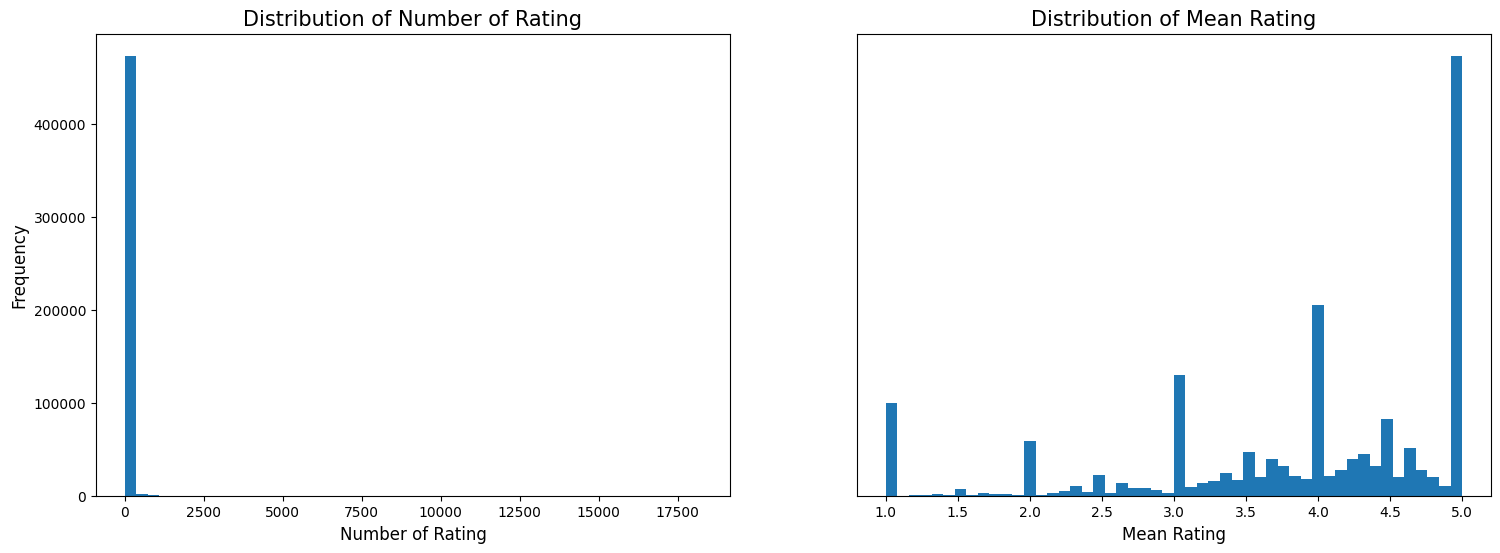

In [12]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.hist(x='Number of Rating',data=df_rating,bins=50)
plt.title('Distribution of Number of Rating', fontsize=15)
plt.xlabel('Number of Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1,2,2)
plt.hist(x='Mean Rating',data=df_rating,bins=50)
plt.title('Distribution of Mean Rating', fontsize=15)
plt.xlabel('Mean Rating', fontsize=12)
plt.yticks([])
plt.show()

From these histograms we can see that most of the number of ratings are between 0 and 2000, and most of the products have an average rating between 3.5-5.

In [13]:
print('Overall Average rating : ',df_rating['Mean Rating'].mean())

Overall Average rating :  3.889700263013201


The mean rating for all the products (C) is 3.9 on a scale of 5.

The next step is to determine an appropriate value for m, the minimum number of votes required for a product to be listed in the chart. We use 90th percentile as our cutoff. In other words, for a product to feature in the charts, the number of its votes should be higher than that of 90% of the products in the list.

In [14]:
df_rating['Number of Rating'].quantile(q=0.9)

25.0

Now, we filter the products that qualify for the chart and put them in a new dataframe called df_filtered.

In [15]:
m=df_rating['Number of Rating'].quantile(q=0.9)
df_filtered = df_rating[df_rating['Number of Rating']>=m]
df_filtered = df_filtered[df_filtered['Mean Rating'] >= df_filtered['Mean Rating'].mean()]

In [16]:
df_filtered

,Number of Rating,Mean Rating
productId,,
0594481813,31,4.225806
0972683275,1051,4.470980
1400501474,29,4.448276
1400501520,82,4.243902
1400698987,138,4.246377
...,...,...
B00KMRGF28,33,4.030303
B00KPRWAX8,35,4.714286
B00KYMCJF8,48,4.458333


In [17]:
df_filtered.describe()

,Number of Rating,Mean Rating
count,27496.000000,27496.000000
mean,143.557536,4.348600
std,396.752701,0.234001
min,25.000000,3.956790
25%,35.000000,4.155415
50%,56.000000,4.336027
75%,117.000000,4.523810
max,18244.000000,5.000000


Now lets build our formula and recommend based on it: 

In [18]:
c=df_rating['Mean Rating'].mean()
def product_score(x,m,c):
    v=x['Number of Rating']
    R=x['Mean Rating']
    return ((R*v)/(v+m))+((c*m)/(v+m))

In [19]:
df_filtered['score']=df_filtered.apply(lambda x: product_score(x,m,c), axis=1)

In [20]:
df_filtered.sort_values('score',ascending=False)

,Number of Rating,Mean Rating,score
productId,,,
B0043WJRRS,2512,4.881369,4.871597
B00CG70K78,237,4.949367,4.848254
B007SZ0E1K,449,4.895323,4.842284
B003FVVMS0,1876,4.853412,4.840738
B0033PRWSW,387,4.901809,4.840394
...,...,...,...
B001SH4ECY,25,3.960000,3.924850
B009G8F6PG,25,3.960000,3.924850
B0013Z9F66,25,3.960000,3.924850


#### Now we have a list of the best 27497 products in our system, these products have high scores based on their ratings and number of ratings. 
#### these scores are not user-specific, which can be used for general suggestions or for our new users with no captured user-product behaviour/information 

## 2. Machine Learning Approach (SVD)

For this section I'll training a ML model to recommend products based on user interactions with other products. 
I'll assume that a recommendation for user-suitable products will have a score >=3 which will be considered "good" for the user, hence any product with a score less than 3 will be considered "bad" for the user

First I'll make sure that each user in my dataset has rated at least 2 products, this is imporant when I split the data for training and testing 
and I'll do that by filtering my data based on that condition 

In [21]:
user_counts = df['userId'].value_counts()[df['userId'].value_counts() >= 2 ]
df_filtered = df[df['userId'].isin(user_counts.index)]
print(df_filtered['userId'].value_counts().min())


2


In [22]:
df_filtered

,userId,productId,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
5,A1QGNMC6O1VW39,0511189877,5.0
6,A3J3BRHTDRFJ2G,0511189877,2.0
7,A2TY0BTJOTENPG,0511189877,5.0
...,...,...,...
7824475,A2R6Q6KJCYSVH7,BT008UKTMW,3.0
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0
7824478,A322MDK0M89RHN,BT008UKTMW,5.0
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0


In [23]:
print('Number of unique users in the dataset:  ', df_filtered['userId'].nunique())

Number of unique users in the dataset:   1319864


Now I'll define my testing data ratio size to be at least the minimum required amount of records to have all the users 

In [24]:
test_size = df_filtered['userId'].nunique()/( len(df_filtered) - df_filtered['userId'].nunique()) 
test_size

0.36432292716158227

In [25]:
df_filtered_train, df_filtered_test = sk_train_test_split(df_filtered,test_size=test_size+0.02,stratify=df_filtered['userId'])

make sure that both sets have the same amount of users 

In [26]:
print('Number of unique users in the training set:  ', df_filtered_train['userId'].nunique())
print('Number of unique users in the testing set:  ', df_filtered_test['userId'].nunique())

Number of unique users in the training set:   1319864
Number of unique users in the testing set:   1319864


Lets read the data using surprise reader and split it into training and testing sets, for training and testing

In [27]:
reader = Reader(rating_scale=(1, 5.0))
trainset = Dataset.load_from_df(df_filtered_train,reader)
testset = Dataset.load_from_df(df_filtered_test,reader)
data = Dataset.load_from_df(df,reader)

Now lets initialize our ML model, and fit it on the training data

In [28]:
svd = SVD()

svd.fit(trainset.build_full_trainset())

Our model is done training, I want to test its behaviour on both the training and testing data

In [29]:
trainset_1 = trainset.build_full_trainset().build_testset() # this line is important to test the model on the training data

### Now lets evaluate our models performance on the training data

In [30]:
train_preds = svd.test(trainset_1)
print(f"the models Mean absolute error on the training data is :{accuracy.mae(train_preds)}, and the Root mean squared error is: {accuracy.rmse(train_preds)}" )

MAE:  0.6027
RMSE: 0.7901
the models Mean absolute error on the training data is :0.6027135955128876, and the Root mean squared error is: 0.7900667150795867


### The function below is derived from Surprise documentation to calculate the measures precision and recall

In [31]:
threshold = 3 

In [32]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

def Surprise_Evaluate(precisions,recalls):
    overall_precision = np.mean(list(precisions.values()))
    overall_recall = np.mean(list(recalls.values()))
    f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall)
    print(f"the models Precision on the training data is :{overall_precision}, and the Recall is: {overall_recall}, and the F1-score is {f1_score}" )
    return overall_precision,overall_recall,f1_score


In [33]:
precisions, recalls = precision_recall_at_k(train_preds, k=50, threshold=threshold)
_,_,_ = Surprise_Evaluate(precisions,recalls)

the models Precision on the training data is :0.865756889605799, and the Recall is: 0.8959203659327636, and the F1-score is 0.8805803979200661


### Now lets evaluate our models performance on the Testing data: 

In [34]:
test_preds = svd.test(testset.build_full_trainset().build_testset())
print(f"the models Mean absolute error on the training data is :{accuracy.mae(test_preds)}, and the Root mean squared error is: {accuracy.rmse(test_preds)}" )

MAE:  0.9377
RMSE: 1.2236
the models Mean absolute error on the training data is :0.9376684312508932, and the Root mean squared error is: 1.2235585645591447


In [35]:
precisions, recalls = precision_recall_at_k(test_preds, k=50, threshold=threshold)
_,_,_ = Surprise_Evaluate(precisions,recalls)

the models Precision on the training data is :0.8349799997231752, and the Recall is: 0.8524215555403659, and the F1-score is 0.8436106367081785


### For further evaluation, I will label the data based on the defined threshold for good and bad products to be recommended for the user
### and then I will calculate the precision , recall , f1-score based on these labels (good , bad ) 

In [36]:
def predict_rating_label(model,uid,iid,threshold=3):
    pred = model.predict(uid=uid,iid=iid).est
    if pred >= threshold : return 'Good'
    else : return 'Bad'

### test the model on training data : 

lets label our training data

In [37]:
df_filtered_train.loc[df_filtered_train['rating'] >= threshold, 'Label'] = 'Good'
df_filtered_train.loc[df_filtered_train['rating'] < threshold, 'Label'] = 'Bad'

In [38]:
df_filtered_train

,userId,productId,rating,Label
7118669,AEN0AQVJUOS1Y,B00BIULEJC,5.0,Good
6695603,A9P7A49W0DP1N,B009R90TTW,5.0,Good
712958,A2XFAVOWDM082N,B000ACGE3U,5.0,Good
2399964,A15C8VPFPQBH0W,B001XZHP5E,5.0,Good
4311851,A1PYI6ST7701G9,B004O4LLU6,5.0,Good
...,...,...,...,...
4232459,A4HJUEM7EU8HV,B004L9M4C8,3.0,Good
184294,A2GPQUV5GEZ07D,B00006HSBC,3.0,Good
1167359,A3IKLLUG4K01JR,B000MKKTKE,3.0,Good
3591762,A3HKRXTGPX7ZNB,B003V4AK4I,5.0,Good


now lets make prediction from the model and calculate our measures 

In [39]:
df_filtered_train['Pred'] = df_filtered_train.apply(lambda x: predict_rating_label(svd,x['userId'],x['productId']),axis=1 )
print(classification_report(df_filtered_train['Label'], df_filtered_train['Pred']))

              precision    recall  f1-score   support

         Bad       0.94      0.51      0.66    432800
        Good       0.92      1.00      0.96   2610276

    accuracy                           0.93   3043076
   macro avg       0.93      0.75      0.81   3043076
weighted avg       0.93      0.93      0.92   3043076



### test the model on testing data : 

lets label our testiung data

In [40]:
df_filtered_test.loc[df_filtered_test['rating'] >= threshold, 'Label'] = 'Good'
df_filtered_test.loc[df_filtered_test['rating'] < threshold, 'Label'] = 'Bad'

In [41]:
df_filtered_test

,userId,productId,rating,Label
1737311,ARI50QA69794B,B0015YWV1G,5.0,Good
841225,A2FWVC35ASXQE4,B000E95FNY,5.0,Good
7321064,A5X444UZBWXW2,B00CUOAWN4,2.0,Bad
6249497,AYEU47H4KVG0H,B008I9CFKS,5.0,Good
7687051,AXCI20F43SEYO,B00G9X5N2W,5.0,Good
...,...,...,...,...
3678111,ASELQGI3L9JFK,B003Y60DZO,5.0,Good
3989996,A376OJHLE6SU9Q,B004AM6SQO,5.0,Good
4447053,A29KZZ4FADQBQY,B004SY9OVA,5.0,Good
6724883,A29BKMC9Y87P3F,B009T3ACGG,2.0,Bad


In [42]:
df_filtered_test['Pred'] = df_filtered_test.apply(lambda x: predict_rating_label(svd,x['userId'],x['productId']),axis=1 )
print(classification_report(df_filtered_test['Label'], df_filtered_test['Pred']))

              precision    recall  f1-score   support

         Bad       0.50      0.07      0.12    278972
        Good       0.86      0.99      0.92   1620602

    accuracy                           0.85   1899574
   macro avg       0.68      0.53      0.52   1899574
weighted avg       0.81      0.85      0.80   1899574



#### We see that the model performs well considering that we didnt perform any hyperparameter tuning, which now will apply

the operation below is a bit costly so I ran the cell once and saved the best_params in a variable 

In [43]:
# param_grid = {
#     'n_factors': [50, 100, 150],
#     'n_epochs': [10, 20, 30],
#     'lr_all': [0.005, 0.01, 0.02],
#     'reg_all': [0.02, 0.1, 0.2]
# }

# # Perform grid search
# grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3,n_jobs=-1)
# grid_search.fit(data)

# # Get the best parameters
# best_params = grid_search.best_params['rmse']


In [44]:
best_params = {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}

In [45]:
# Train the final model with the best parameters on the entire dataset
svd_tuned = SVD(**best_params)
svd_tuned.fit(trainset.build_full_trainset())

In [46]:
df_filtered_test['Pred_tuned'] = df_filtered_test.apply(lambda x: predict_rating_label(svd_tuned,x['userId'],x['productId']),axis=1 )
print(classification_report(df_filtered_test['Label'], df_filtered_test['Pred_tuned']))

              precision    recall  f1-score   support

         Bad       0.54      0.09      0.15    278972
        Good       0.86      0.99      0.92   1620602

    accuracy                           0.86   1899574
   macro avg       0.70      0.54      0.53   1899574
weighted avg       0.82      0.86      0.81   1899574



the tuned model performs slightly better than the un-tuned model :) 

## to save the model run the cell below 

In [47]:
# Compute predictions of the 'original' algorithm.
predictions = svd_tuned.test(data.build_full_trainset().build_testset())

# Dump algorithm and reload it.
file_name = "dump_file"
dump.dump(file_name, algo=svd_tuned)
_, loaded_algo = dump.load(file_name)

# We now ensure that the algo is still the same by checking the predictions.
predictions_loaded_algo = loaded_algo.test(data.build_full_trainset().build_testset())
assert predictions == predictions_loaded_algo
print("Predictions are the same")

Predictions are the same


### Now lets make recommendations using this model, I'm choosing the user 'A44NKM7QY2BC1' as an example

In [48]:
df[df['userId']=='A44NKM7QY2BC1']

,userId,productId,rating
174311,A44NKM7QY2BC1,B00006B9CR,1.0
3089708,A44NKM7QY2BC1,B0036ECGS6,4.0


In [49]:

def generate_recommendation(model, user_id, df, top_n,threshold=3):
    """
    Generate recommendations for a user using a collaborative filtering model.

    Parameters:
    - model (obj): The collaborative filtering model trained using Surprise.
    - user_id (int): The user for whom recommendations are generated.
    - df (DataFrame): The input DataFrame containing user-item interactions.
    - top_n (int): The number of top recommendations to return.

    Returns:
    - DataFrame: A DataFrame containing the top recommendations for the user.
    """

    # Get unique product ids in the dataset
    product_ids = df["productId"].unique()

    # Get product ids already interacted by the user
    product_ids_user = df.loc[df["userId"] == user_id, "productId"]

    # Find product ids not interacted by the user
    product_ids_to_pred = np.setdiff1d(product_ids, product_ids_user)

    # Create a test set for predictions
    test_set = [[user_id, product_id, None] for product_id in product_ids_to_pred]

    # Make predictions using the collaborative filtering model
    predictions = model.test(test_set)

    # Extract item ids and estimated ratings from predictions
    predictions = np.array([(pred.iid, pred.est) for pred in predictions])

    # Create a DataFrame from predictions
    predictions_df = pd.DataFrame(predictions, columns=['iid', 'est'])

    # Sort predictions by estimated ratings in descending order and select top N
    predictions_df = predictions_df.sort_values('est', ascending=False)[:top_n]

    # Add user_id column to the DataFrame
    predictions_df['uid'] = user_id
    predictions_df['est'] = predictions_df['est'].astype(float)

    predictions_df.loc[predictions_df['est'] >= threshold, 'Label'] = 'Good'
    predictions_df.loc[predictions_df['est'] < threshold, 'Label'] = 'Bad'

    return predictions_df[predictions_df['Label']=='Good']

In [50]:
# define which user ID that we want to give recommendation
userID = 'A44NKM7QY2BC1'
# generate recommendation using the model that we have trained, and return the good products to be recommended 
user_recommendations = generate_recommendation(svd_tuned,userID,df,top_n=50,threshold = threshold)

user_recommendations.head(10)

,iid,est,uid,Label
74145,B000P22S2Q,4.397901,A44NKM7QY2BC1,Good
197920,B003WSUZH0,4.365942,A44NKM7QY2BC1,Good
147256,B002LGYIHW,4.363211,A44NKM7QY2BC1,Good
44462,B000B4WL1G,4.356051,A44NKM7QY2BC1,Good
69609,B000MVEC10,4.339008,A44NKM7QY2BC1,Good
60405,B000HW5WRW,4.338653,A44NKM7QY2BC1,Good
346848,B008JGWY2Y,4.333858,A44NKM7QY2BC1,Good
108143,B001CY652K,4.320550,A44NKM7QY2BC1,Good
367114,B009I2BRUS,4.319895,A44NKM7QY2BC1,Good
450633,B00G3MP39M,4.318946,A44NKM7QY2BC1,Good
